In [189]:
%matplotlib inline


#imports
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


### Get Data

In [156]:
revisions_df = pd.read_csv(f'500_revisions.csv')

In [157]:
# We will only work on the label creation for the momment
label_creation_df = revisions_df.loc[((~revisions_df.label.isna()) & (revisions_df.action == 'add'))]

In [246]:
label_creation_df.sample()

,revid,timestamp,label,description,alias,action,language,property,rating
16797,323963857,2016-04-21T02:05:09Z,es,NaN,NaN,add,es,P2755,1


In [247]:
label_creation_df['rating'] = 1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [248]:
num_languages = label_creation_df.language.nunique()
num_properties = label_creation_df.property.nunique()

print("PROPERTIES: {} LANGUAGES: {}".format(num_properties, num_languages))

PROPERTIES: 476 LANGUAGES: 152


In [249]:
# Normalize in [0, 1]

#r = df['rating'].values.astype(float)
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(r.reshape(-1,1))
#df_normalized = pd.DataFrame(x_scaled)
#df['rating'] = df_normalized

In [250]:
label_creation_df.sample()

,revid,timestamp,label,description,alias,action,language,property,rating
21075,175990569,2014-11-22T14:31:53Z,scn,NaN,NaN,add,scn,P918,1


In [251]:
# Convert DataFrame in user-item matrix

matrix = label_creation_df.pivot_table(index='property', columns='language', values='rating')
matrix.fillna(0, inplace=True)

# Users and items ordered as they are in matrix

properties = matrix.index.tolist()
languages = matrix.columns.tolist()

matrix = matrix.as_matrix()
#matrix = matrix.values()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [252]:
# Network Parameters

num_input = num_languages
num_hidden_1 = 30
num_hidden_2 = 10

X = tf.placeholder(tf.float64, [None, num_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1], dtype=tf.float64)),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2], dtype=tf.float64)),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1], dtype=tf.float64)),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input], dtype=tf.float64)),
}

biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1], dtype=tf.float64)),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2], dtype=tf.float64)),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1], dtype=tf.float64)),
    'decoder_b2': tf.Variable(tf.random_normal([num_input], dtype=tf.float64)),
}

In [253]:
# Building the encoder

def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    return layer_2


# Building the decoder

def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    return layer_2


# Construct model

encoder_op = encoder(X)
decoder_op = decoder(encoder_op)


# Prediction

y_pred = decoder_op


# Targets are the input data.

y_true = X

In [254]:
# Define loss and optimizer, minimize the squared error

loss = tf.losses.mean_squared_error(y_true, y_pred)
optimizer = tf.train.RMSPropOptimizer(0.03).minimize(loss)

predictions = pd.DataFrame()

# Define evaluation metrics

eval_x = tf.placeholder(tf.int32, )
eval_y = tf.placeholder(tf.int32, )
pre, pre_op = tf.metrics.precision(labels=eval_x, predictions=eval_y)

In [255]:
# Initialize the variables (i.e. assign their default value)

init = tf.global_variables_initializer()
local_init = tf.local_variables_initializer()

In [256]:
with tf.Session() as session:
    epochs = 100
    batch_size = 25

    session.run(init)
    session.run(local_init)

    num_batches = int(matrix.shape[0] / batch_size)
    matrix = np.array_split(matrix, num_batches)

    for i in range(epochs):

        avg_cost = 0

        for batch in matrix:
            _, l = session.run([optimizer, loss], feed_dict={X: batch})
            avg_cost += l

        avg_cost /= num_batches

        print("Epoch: {} Loss: {}".format(i + 1, avg_cost))

    print("Predictions...")

    matrix_copy = np.concatenate(matrix, axis=0)

    preds = session.run(decoder_op, feed_dict={X: matrix_copy})

    predictions = predictions.append(pd.DataFrame(preds))

    predictions = predictions.stack().reset_index(name='rating')
    predictions.columns = ['property', 'language','rating']
    predictions['property'] = predictions['property'].map(lambda value: properties[value])
    predictions['language'] = predictions['language'].map(lambda value: languages[value])

Epoch: 1 Loss: 0.4232324220632252
Epoch: 2 Loss: 0.4206306479479137
Epoch: 3 Loss: 0.41368307722242253
Epoch: 4 Loss: 0.3959893646993135
Epoch: 5 Loss: 0.35682693908089086
Epoch: 6 Loss: 0.2914858013391495
Epoch: 7 Loss: 0.18801125217425196
Epoch: 8 Loss: 0.13734932479105497
Epoch: 9 Loss: 0.11160743628677569
Epoch: 10 Loss: 0.08998055265922296
Epoch: 11 Loss: 0.08423255011439323
Epoch: 12 Loss: 0.06624264015178931
Epoch: 13 Loss: 0.05687768708326315
Epoch: 14 Loss: 0.0548493221990372
Epoch: 15 Loss: 0.04753034405018154
Epoch: 16 Loss: 0.045116721211295376
Epoch: 17 Loss: 0.045623775277482834
Epoch: 18 Loss: 0.0428278723633603
Epoch: 19 Loss: 0.041919256021317686
Epoch: 20 Loss: 0.04197641207199348
Epoch: 21 Loss: 0.042890559587823715
Epoch: 22 Loss: 0.040420938185171076
Epoch: 23 Loss: 0.040594982767575664
Epoch: 24 Loss: 0.0409047552629521
Epoch: 25 Loss: 0.0389139153749535
Epoch: 26 Loss: 0.039895090568614636
Epoch: 27 Loss: 0.03873214120731542
Epoch: 28 Loss: 0.03846924879441136
Ep

In [257]:
predictions = predictions.sort_values(by=['rating'],ascending=False)

In [258]:
rrr = label_creation_df.pivot_table(index='property', columns='language', values='rating')
rrr.fillna(0, inplace=True)
rrr= pd.DataFrame(rrr.unstack())
rrr.reset_index(inplace=True)
rrr.columns = [ 'language','property','actual_rating']

In [259]:
aaa = pd.merge(predictions,rrr,how='inner',left_on=['property','language'],right_on=['property','language'])

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


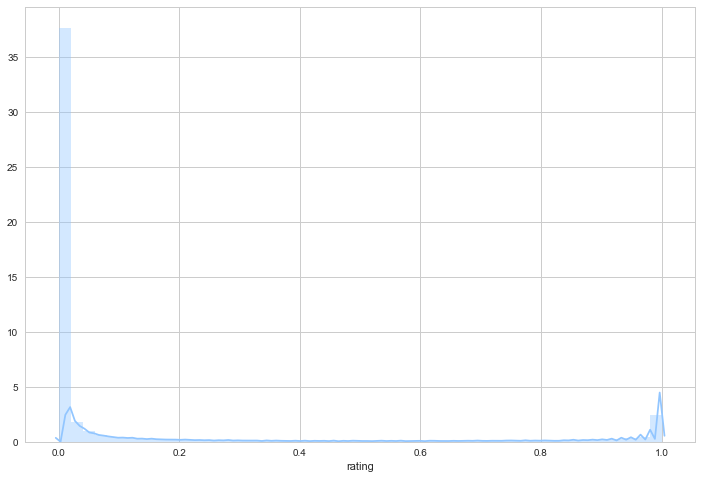

In [260]:
plt.figure(figsize=(12,8))
sns.distplot(aaa.rating)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


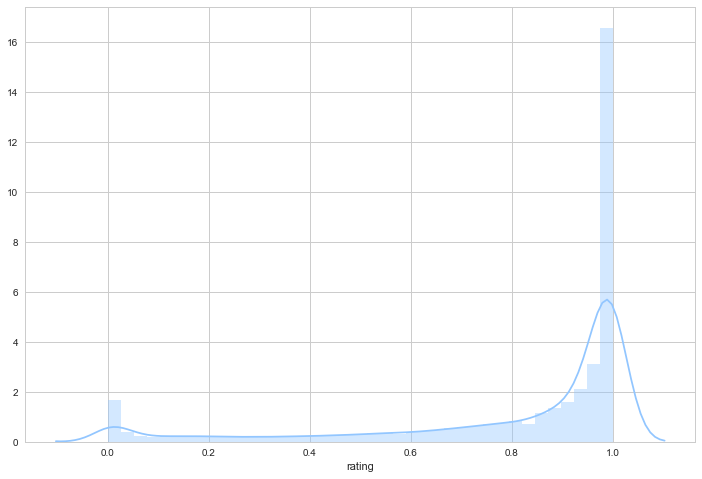

In [261]:
plt.figure(figsize=(12,8))
sns.distplot(aaa.loc[aaa.actual_rating == 1,'rating'])

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


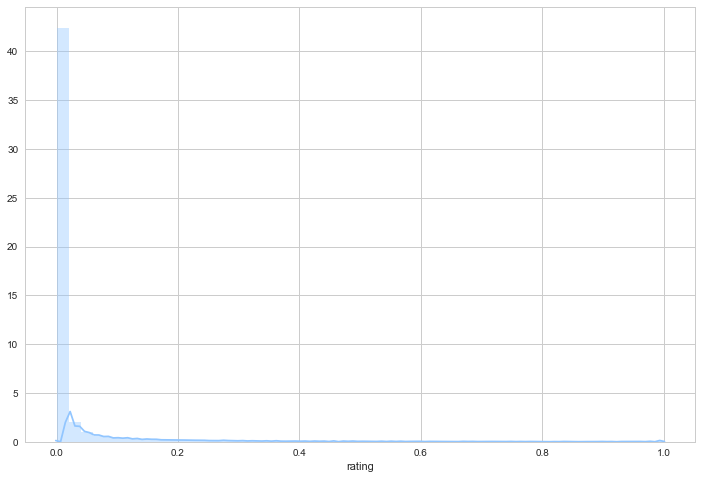

In [262]:
plt.figure(figsize=(12,8))
sns.distplot(aaa.loc[aaa.actual_rating == 0,'rating'])

In [263]:
pd.options.display.float_format = '{:,.4f}'.format
aaa.loc[aaa.actual_rating==0]

,property,language,rating,actual_rating
143,P2146,uk,1.0000,0.0000
228,P4873,uk,1.0000,0.0000
318,P3020,uk,1.0000,0.0000
354,P4875,uk,1.0000,0.0000
418,P2769,ar,1.0000,0.0000
553,P3473,mk,1.0000,0.0000
592,P3381,uk,1.0000,0.0000
638,P649,es,1.0000,0.0000
691,P1233,uk,0.9999,0.0000
763,P3441,ru,0.9999,0.0000
